<a href="https://colab.research.google.com/github/Krittika20/Review_sentiment-recommendation/blob/main/4_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn import metrics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cleaned_data = pd.read_csv("/content/drive/MyDrive/cleaned_data2.csv")

In [5]:
cleaned_data.head(5)

,reviewerID,reviewText,clean_reviewText,clean_summary,rating_class
0,A1BZ18U2EF4FAI,the nook color is a great tablet. it sometimes...,nook color great tablet sometimes slow still t...,good,good
1,A3W2CJFXG0158G,"1. I have a iPhone3Gs with a case, the cable w...",phone is case win without remove case manage p...,first belkin disappointment,bad
2,A3F9CBHV4OHFBS,I needed this cable to connect my Epson projec...,need connect elson project lawton great price ...,great product especially price,good
3,AZHV16QDXACKC,i bought these over a year ago hoping that a c...,year ago hop company offer lifetime warranty p...,not great,bad
4,A231WM2Z2JL0U3,or those who shun manuals. I am a fairly compu...,shun manual fairly computer-navvy person hande...,not faint-hearted,bad


In [6]:
cleaned_data["rating_class"] = cleaned_data["rating_class"].apply(lambda x: 1 if x=="good" else 0)

In [7]:
cleaned_data.head(5)

,reviewerID,reviewText,clean_reviewText,clean_summary,rating_class
0,A1BZ18U2EF4FAI,the nook color is a great tablet. it sometimes...,nook color great tablet sometimes slow still t...,good,1
1,A3W2CJFXG0158G,"1. I have a iPhone3Gs with a case, the cable w...",phone is case win without remove case manage p...,first belkin disappointment,0
2,A3F9CBHV4OHFBS,I needed this cable to connect my Epson projec...,need connect elson project lawton great price ...,great product especially price,1
3,AZHV16QDXACKC,i bought these over a year ago hoping that a c...,year ago hop company offer lifetime warranty p...,not great,0
4,A231WM2Z2JL0U3,or those who shun manuals. I am a fairly compu...,shun manual fairly computer-navvy person hande...,not faint-hearted,0


In [8]:
Y = cleaned_data["rating_class"]
X = cleaned_data["clean_reviewText"]

In [9]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
X_tfidf = tfidf_vect.fit_transform(X.values.astype("U"))
X_tfidf  = X_tfidf.toarray()

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selectK = SelectKBest(f_classif, k=1000)
selectK.fit(X_tfidf, Y)
X_sel = selectK.transform(X_tfidf)

In [11]:
tfidf_vect_train, tfidf_vect_test, Y_train, Y_test = train_test_split(X_sel, Y, test_size=0.2, random_state=42,shuffle=True, stratify = Y)

In [12]:
model = xgb.XGBClassifier(n_estimators=100, learning_rate =0.20, max_depth = 30,min_child_weight= 5,gamma = 0.5,colsample_bytree = 0.4)
t0 = time.time()
eval_s = [(tfidf_vect_train, Y_train), (tfidf_vect_test, Y_test)]
model.fit(tfidf_vect_train, Y_train, eval_metric=["aucpr","error"], verbose=True, eval_set = eval_s, early_stopping_rounds=20)
t1 = time.time()
xg_Ypred = model.predict(tfidf_vect_test)
t2 = time.time()
xg_time_linear_train = t1-t0
xg_time_linear_predict = t2-t1
xg_f1Score = f1_score(Y_test, xg_Ypred, average = "weighted")

[0]	validation_0-aucpr:0.775271	validation_0-error:0.29325	validation_1-aucpr:0.69504	validation_1-error:0.359
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-aucpr:0.842361	validation_0-error:0.2275	validation_1-aucpr:0.751136	validation_1-error:0.308
[2]	validation_0-aucpr:0.874654	validation_0-error:0.19925	validation_1-aucpr:0.784726	validation_1-error:0.279
[3]	validation_0-aucpr:0.898486	validation_0-error:0.1785	validation_1-aucpr:0.800627	validation_1-error:0.261
[4]	validation_0-aucpr:0.909085	validation_0-error:0.16575	validation_1-aucpr:0.802882	validation_1-error:0.263
[5]	validation_0-aucpr:0.918584	validation_0-error:0.15425	validation_1-aucpr:0.813667	validation_1-error:0.247
[6]	validation_0-aucpr:0.925826	validation_0-error:0.146	validation_1-aucpr:0.816835	validation_1-error:0.249
[7]	validation_0-aucpr:0.933962	validation_0-error:0.14	vali

In [13]:
data_dmatrix = xgb.DMatrix(data=tfidf_vect_train,label=Y_train)

In [14]:
params =  {"objective":"binary:logistic",'colsample_bytree': 0.4,'learning_rate': 0.20,
                'max_depth': 30, 'gamma': 0.5}
cv_result = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="error", as_pandas=True, seed=123)

In [15]:
cv_result.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.233749,0.010828,0.368749,0.011752
1,0.153500,0.003412,0.322748,0.016404
2,0.130001,0.007576,0.296002,0.014594
3,0.110124,0.005890,0.282755,0.018603
4,0.092125,0.004165,0.272754,0.012249


In [16]:
print("Training time: %fs; Prediction time: %fs" % (xg_time_linear_train, xg_time_linear_predict))

Training time: 30.730822s; Prediction time: 0.019425s


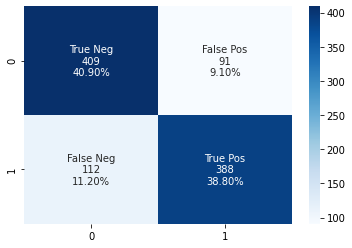

In [17]:
import seaborn as sns
import numpy as np 

cf_matrix = metrics.confusion_matrix(Y_test, xg_Ypred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [18]:
xg_f1Score

0.7969104375029388

In [19]:
model = CatBoostClassifier(iterations=300, learning_rate=0.1, max_depth = 8)
t0 = time.time()
model.fit(tfidf_vect_train, Y_train)
t1 = time.time()
cat_Ypred = model.predict(tfidf_vect_test)
t2 = time.time()
cat_time_linear_train = t1-t0
cat_time_linear_predict = t2-t1
cat_f1Score = f1_score(Y_test, cat_Ypred, average = "weighted")

0:	learn: 0.6760537	total: 592ms	remaining: 2m 56s
1:	learn: 0.6548140	total: 868ms	remaining: 2m 9s
2:	learn: 0.6447067	total: 1.14s	remaining: 1m 52s
3:	learn: 0.6300647	total: 1.41s	remaining: 1m 44s
4:	learn: 0.6179865	total: 1.7s	remaining: 1m 40s
5:	learn: 0.6073360	total: 1.97s	remaining: 1m 36s
6:	learn: 0.5977972	total: 2.23s	remaining: 1m 33s
7:	learn: 0.5892094	total: 2.5s	remaining: 1m 31s
8:	learn: 0.5817280	total: 2.78s	remaining: 1m 29s
9:	learn: 0.5743804	total: 3.06s	remaining: 1m 28s
10:	learn: 0.5696996	total: 3.33s	remaining: 1m 27s
11:	learn: 0.5644111	total: 3.6s	remaining: 1m 26s
12:	learn: 0.5607004	total: 3.88s	remaining: 1m 25s
13:	learn: 0.5561395	total: 4.14s	remaining: 1m 24s
14:	learn: 0.5515005	total: 4.42s	remaining: 1m 24s
15:	learn: 0.5473616	total: 4.72s	remaining: 1m 23s
16:	learn: 0.5431200	total: 5s	remaining: 1m 23s
17:	learn: 0.5397574	total: 5.27s	remaining: 1m 22s
18:	learn: 0.5361742	total: 5.54s	remaining: 1m 21s
19:	learn: 0.5312775	total: 5

In [20]:
print("Training time: %fs; Prediction time: %fs" % (cat_time_linear_train, cat_time_linear_predict))

Training time: 83.284347s; Prediction time: 0.372354s


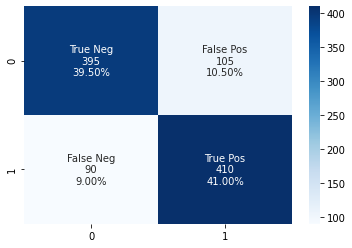

In [21]:
cf_matrix = metrics.confusion_matrix(Y_test, cat_Ypred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [22]:
cat_f1Score

0.8049561151259034

In [23]:
model = svm.SVC(C = 10)
t0 = time.time()
model.fit(tfidf_vect_train, Y_train)
t1 = time.time()
svc_Ypred = model.predict(tfidf_vect_test)
t2 = time.time()
svc_time_linear_train = t1-t0
svc_time_linear_predict = t2-t1
svc_f1Score = f1_score(Y_test, svc_Ypred, average = "weighted")

In [24]:
print("Training time: %fs; Prediction time: %fs" % (svc_time_linear_train, svc_time_linear_predict))

Training time: 25.361872s; Prediction time: 4.905240s


In [25]:
svc_f1Score

0.8129773702618017

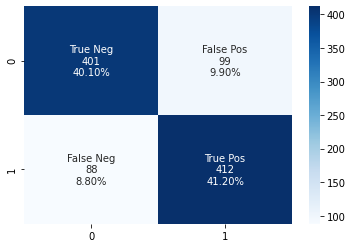

In [26]:
cf_matrix = metrics.confusion_matrix(Y_test, svc_Ypred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [27]:
f1_scores = [svc_f1Score, cat_f1Score, xg_f1Score]
train_time = [svc_time_linear_train, cat_time_linear_train, xg_time_linear_train]
predict_time = [svc_time_linear_predict, cat_time_linear_predict, xg_time_linear_predict]
algo_name = ["SVC", "CatBoost", "XGBoost"]

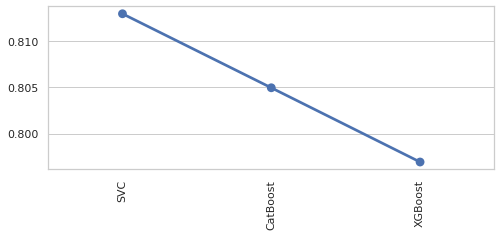

In [28]:
f1_scores = [svc_f1Score, cat_f1Score, xg_f1Score]
train_time = [svc_time_linear_train, cat_time_linear_train, xg_time_linear_train]
predict_time = [svc_time_linear_predict, cat_time_linear_predict, xg_time_linear_predict]
algo_name = ["SVC", "CatBoost", "XGBoost"]

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
sns.set_theme(style = "whitegrid")
ax = sns.pointplot(x = algo_name, y = f1_scores)
ax.set_xticklabels(ax.get_xticklabels() , rotation = 90)
plt.show()

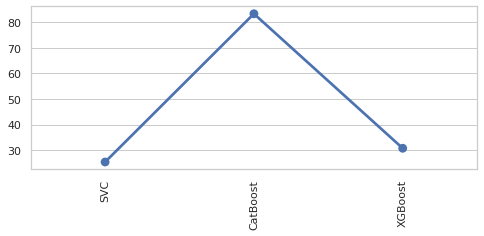

In [29]:
plt.figure(figsize=(8,3))
sns.set_theme(style = "whitegrid")
bx = sns.pointplot(x = algo_name, y = train_time)
bx.set_xticklabels(ax.get_xticklabels() , rotation = 90)
plt.show()

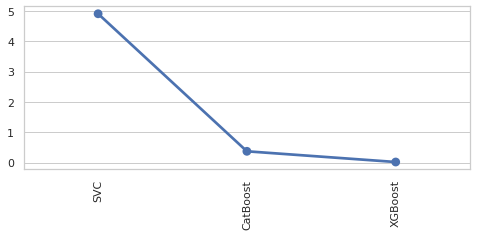

In [30]:
plt.figure(figsize=(8,3))
sns.set_theme(style = "whitegrid")
cx = sns.pointplot(x = algo_name, y = predict_time)
cx.set_xticklabels(ax.get_xticklabels() , rotation = 90)
plt.show()